# devlog 2023-07-24

_author: Tyler Coles_

Prototype IPM Adapter.

How can we define new IPMs by supplying a set of transforms?

This solution leaves much to be desired, but it does work. I think a better solution would define a declarative model to represent these concepts. This would allow us to do proactive validation and hopefully achieve a simpler syntax.

Sequence diagram for the AdapterBuilder (Outer) to ModelBuilder (Inner) relationship:

(Embedding mermaid in Jupyter is a bit of a mess, but you can pop this into https://mermaid.live/ to see it.)

```mermaid
sequenceDiagram
  participant Run
  participant A as AdapterBuilder
  participant B as ModelBuilder

  Run->>A: init(model)
  A->>B: init(altered_model)
  Run->>+A: build(outer_ctx)
  A->>A: map_ctx
  A->>+B: build(inner_ctx)
  B-->>-A: IPM
  A-->>-Run: IPM
```

In [1]:
import dataclasses
from datetime import date
from typing import Callable, cast
from epymorph.context import SimContext
from epymorph.ipm.attribute import AttributeDef, geo, param, verify_attribute
from epymorph.ipm.compartment_ipm import CompartmentModelIpmBuilder

import numpy as np

from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.ipm.compartment_model import CompartmentModel
from epymorph.ipm.ipm import Ipm
from epymorph.run import plot_event
from epymorph.simulation import Simulation
from epymorph.util import list_not_none


class AdapterCompartmentModelIpmBuilder(CompartmentModelIpmBuilder):
    # NOTE: this implementation will not catch errors in the definition
    # if I leave out an attribute or don't properly map to the underlying model,
    # resulting behavior is undefined rather than a pro-active error

    # Properties documented in the use-case below.

    outer_attribs: list[AttributeDef]
    inner_attribs: list[AttributeDef]
    map_ctx: Callable[[SimContext], SimContext]

    def __init__(self,
                 model: CompartmentModel,
                 outer_attribs: list[AttributeDef],
                 inner_attribs: list[AttributeDef] | None,
                 map_ctx: Callable[[SimContext], SimContext]):
        if inner_attribs is None:
            inner_attribs = model.attributes
        new_model = dataclasses.replace(model, attributes=inner_attribs)
        super().__init__(new_model)
        self.outer_attribs = outer_attribs
        self.inner_attribs = inner_attribs
        self.map_ctx = map_ctx

    def verify(self, ctx: SimContext) -> None:
        # NOTE: could be refactored in the base class to avoid copy-pasta
        errors = list_not_none(verify_attribute(ctx, a)
                               for a in self.outer_attribs)
        if len(errors) > 0:
            raise Exception("IPM attribute requirements were not met. "
                            + "See errors:" + "".join(f"\n- {e}" for e in errors))

    def build(self, ctx: SimContext) -> Ipm:
        inner = self.map_ctx(ctx)
        return super().build(inner)

In [2]:
# Our "inner" builder.
sirs_builder = cast(CompartmentModelIpmBuilder, ipm_library['sirs']())


# This function maps the outer context to the form expected by the inner model.
# Basically, define the inner model's attribs in terms of the outer model's attribs.
def map_ctx(outer: SimContext) -> SimContext:
    H = outer.geo['humidity']
    D = outer.param['infection_duration']
    L = outer.param['immunity_duration']
    inner = outer._replace(param={
        **outer.param,  # no harm in passing through more params than needed
        'beta': (1.3 + np.exp(-180 * H + np.log(2.0 - 1.3))) / D,
        'gamma': 1 / D,
        'xi': 1 / L,
    })
    return inner


# Our "outer" builder.
pei_builder = AdapterCompartmentModelIpmBuilder(
    # The base model being adapted.
    model=sirs_builder.model,
    # Which attributes need to be checked at the outer boundary?
    outer_attribs=[
        param('D', 'infection_duration'),
        param('L', 'immunity_duration'),
        geo('H', 'humidity', shape='TxN'),
    ],
    # Which attributes exist at the inner boundary?
    # Here we need to alter beta to accept TxN data; the base SIRS model just accepts a scalar beta.
    # Due to numpy magic this "just works" as long as attribute.compile_getter returns the right thing.
    inner_attribs=[
        *(a for a in sirs_builder.model.attributes if a.attribute_name != 'beta'),
        param('beta', shape='TxN')
    ],
    map_ctx=map_ctx
)

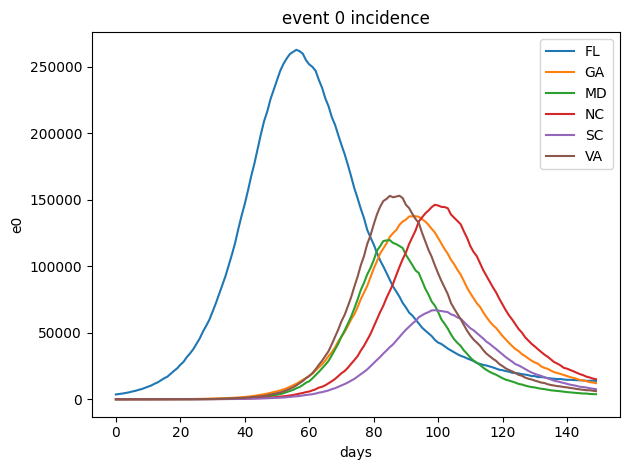

In [3]:
# Now just build and run the sim as usual.

sim = Simulation(
    geo=geo_library['pei'](),  # we know this geo provides humidity
    ipm_builder=pei_builder,
    mvm_builder=mm_library['pei']()
)

out = sim.run(
    param={
        # movement params
        'theta': 0.1,
        'move_control': 0.9,

        # initializer params
        'infection_seed_loc': 0,
        'infection_seed_size': 10_000,

        # and our new "outer" IPM params
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
    },
    start_date=date(2015, 1, 1),
    duration_days=150,
)

plot_event(out, 0)